<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo10-q-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Networks

In this notebook, we will explore policy learning in RL by appropriately training neural networks for predicting Q-functions. These will be called Deep Q-networks (or DQN).  This notebook is taken from this [excellent repo](https://github.com/Curt-Park/rainbow-is-all-you-need).

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    !pip install gym
    !pip install gym[box2d]
    !apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 23 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

# DQN training

At a very high level, Q-learning is simple to grasp. In [class](https://chinmayhegde.github.io/dl-notes/notes/lecture10/) we showed that Q-learning can be viewed as optimizing the Bellman error:
$$
L = \frac{1}{2} \mathbb{E} (r + \gamma \max_{a'} Q(s',a') - Q(s,a))^2
$$
where the expectation is taken over sample 4-tuples $(s,a,r,s')$, and the variables in the loss function are the parameters of a deep neural network that approximates $Q$. 


In practical Q-learning, there are 3 more points to keep in mind:

* *Target updates vs prediction updates*. There are two places where $Q$ appears in the Bellman error above, but really we are keeping the $Q$ in the second part, i.e., the $r + \gamma \max Q(s',a')$ in the Bellman error *fixed*. In other words, the ``target'' value is fixed (and updated only occasionally) while the prediction is updated with every sample.

* *Gradient clipping* -- The Bellman error defined above involves a squared-error loss, but in order to prevent gradient blow-ups, it is common to *clip* the gradient to $\pm 1$. This is equivalent to replacing the squared error loss with the [smoothed L1 loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html).

* *Experience replay*. The 4-tuples $(s,a,r,s')$ are obtained by keeping track of trajectories/episodes that happen over time. This history is stored in a deque, or ND-array, called a *replay buffer*, which can be queried uniformly at random to extract samples.

Let us see how this works. First we perform some standard imports.


In [2]:
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output



Let us now implement a replay buffer using `numpy.ndarray`.


Reference: [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

Our DQN is going to be rather simple, with 2 hidden layers and ReLU activations.

In [17]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

We can now declare a DQNAgent class for the OpenAI gym environment.

In [52]:
env = gym.make('LunarLander-v2')
num_frames = 40000
memory_size = 1000
batch_size = 32
target_update = 100


# device: cpu / gpu
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# networks: dqn, dqn_target
dqn = Network(obs_dim, action_dim).to(device)
dqn_target = Network(obs_dim, action_dim).to(device)
dqn_target.load_state_dict(dqn.state_dict())
dqn_target.eval()

# optimizer
optimizer = optim.Adam(dqn.parameters())

# transition to store in memory
transition = list()

The first helper function we'll describe helps us select the next action. In reinforcement learning, there is a tradeoff between exploitation (choosing actions we know are good again) and exploration (finding new good actions).

In Q-learning, we balance the tradeoff by at first selecting random actions with high probability and then slowly selecting more of the actions we know are good (using our Q function).

In [28]:
def select_action(state, epsilon, dqn, device, memory=None):
  """Select an action from the input state."""
  # epsilon greedy policy
  if epsilon > np.random.random():
      selected_action = env.action_space.sample()
  else:
      selected_action = dqn(
          torch.FloatTensor(state).to(device)
      ).argmax()
      selected_action = selected_action.detach().cpu().numpy()

  next_state, reward, done, _ = env.step(selected_action)

  if memory != None:
    memory.store(state, selected_action, reward, next_state, done)
 
  return selected_action, next_state, reward, done
    

We also need a function for computing the loss. Remember the loss is described by

$$
L = \frac{1}{2} \mathbb{E} (r + \gamma \max_{a'} Q(s',a') - Q(s,a))^2
$$

where $Q$ is `dqn` and $Q'$ is `dqn_target`. The below code computes this loss.

In [29]:
def compute_dqn_loss(dqn, dqn_target, gamma, samples, device):
  """Return dqn loss."""
  state = torch.FloatTensor(samples["obs"]).to(device)
  next_state = torch.FloatTensor(samples["next_obs"]).to(device)
  action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
  reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
  done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)


  curr_q_value = dqn(state).gather(1, action)
  next_q_value = dqn_target(
      next_state
  ).max(dim=1, keepdim=True)[0].detach()
  mask = 1 - done
  target = (reward + gamma * next_q_value * mask).to(device)

  # calculate dqn loss
  loss = F.smooth_l1_loss(curr_q_value, target)

  return loss

It would also be nice to see how we're doing so far with a nice plot.

In [30]:
def custom_plot(frame_idx, scores, losses, epsilons):
  clear_output(True)
  plt.figure(figsize=(20, 5))
  plt.subplot(131)
  plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
  plt.plot(scores)
  plt.subplot(132)
  plt.title('loss')
  plt.plot(losses)
  plt.subplot(133)
  plt.title('epsilons')
  plt.plot(epsilons)
  plt.show()

Now we define the function that we'll use to train.

In [46]:
def train(dqn, dqn_target, env, num_frames, batch_size, plotting_interval=200):
  epsilon_decay = 1 / 2000
  max_epsilon = 1
  min_epsilon = .1
  epsilon = max_epsilon
  gamma = .99
  obs_dim = env.observation_space.shape[0]
  memory = ReplayBuffer(obs_dim, memory_size, batch_size)

  device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
  )
        
  state = env.reset()
  update_cnt = 0
  epsilons = []
  losses = []
  scores = []
  score = 0

  for frame_idx in range(1, num_frames + 1):
      action, next_state, reward, done = select_action(
          state, epsilon, dqn, device, memory=memory
      )

      state = next_state
      score += reward

      # if episode ends
      if done:
          state = env.reset()
          scores.append(score)
          score = 0

      # if ready to train
      if len(memory) >= batch_size:
          samples = memory.sample_batch()
  
          # Forward pass
          loss = compute_dqn_loss(dqn, dqn_target, gamma, samples, device)
  
          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          losses.append(loss.item())
          update_cnt += 1
          
          # linearly decrease epsilon
          epsilon -= epsilon_decay
          epsilon = max(epsilon, min_epsilon)
          epsilons.append(epsilon)
          
          # if hard update is needed
          if update_cnt % target_update == 0:
            dqn_target.load_state_dict(dqn.state_dict())

      # plotting
      if frame_idx % plotting_interval == 0:
          custom_plot(frame_idx, scores, losses, epsilons)
          
  env.close()

When training, we sometimes randomly take an action. However, when we test, we'll only take the action we think is best. And we won't compute loss or anything like that so it's much simpler.

In [36]:
def test(dqn, env):
  state = env.reset()
  done = False
  score = 0
  
  frames = []
  epsilon = 0
  while not done:
      frames.append(env.render(mode="rgb_array"))
      action, next_state, reward, done = select_action(state, epsilon, dqn, device)

      state = next_state
      score += reward
  
  print("score: ", score)
  env.close()
  
  return frames

Before we train, let's try watching what our random DQN does.

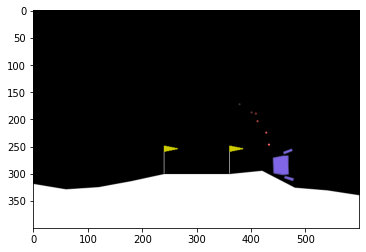

In [54]:
frames = test(dqn, env)

for frame_idx in range(len(frames)):
  plt.imshow(frames[frame_idx])
  plt.show()
  clear_output(True)

So it's pretty bad (as we'd expect). Now let's train it and see if we can get improvement.

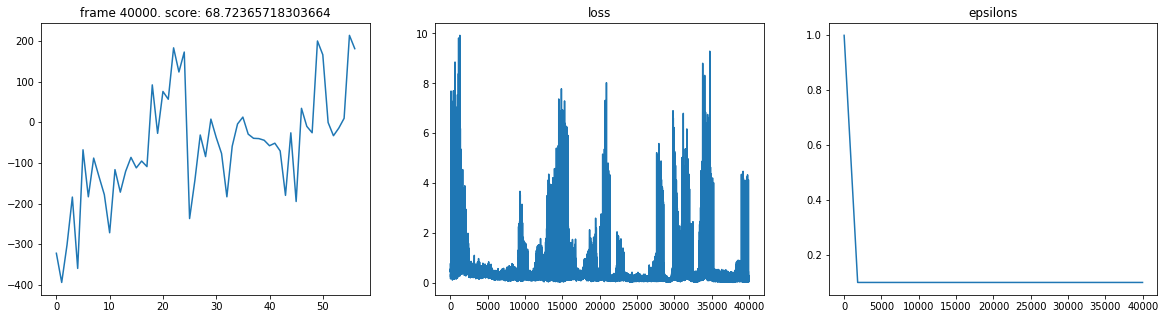

In [49]:
train(dqn, dqn_target, env, num_frames, batch_size)

The next thing we'll do is test to see how we did.

In [50]:
frames = test(dqn, env)

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


score:  203.0974864322161


And we can actually see how good the DQN became!

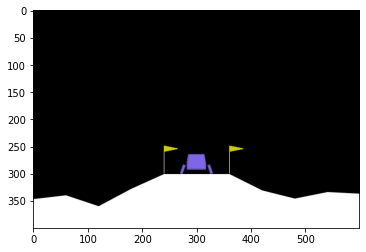

In [51]:
for frame_idx in range(len(frames)):
  plt.imshow(frames[frame_idx])
  plt.show()
  clear_output(True)